## Time Series Forecasting: Predicting Retail Sales

In [2]:
# Import Important Libraries

# Setup feedback system
!pip install learntools
!pip install learntools==0.0.12
!pip show learntools
!pip install learntools==0.0.10
!pip install prophet

# Setup notebook
from pathlib import Path
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import joblib
import streamlit as st
from prophet import Prophet  
from prophet.plot import plot_components_plotly
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

  Using cached learntools-0.0.12-py3-none-any.whl.metadata (331 bytes)
Using cached learntools-0.0.12-py3-none-any.whl (5.2 kB)
  Attempting uninstall: learntools
    Found existing installation: learntools 0.0.10
    Uninstalling learntools-0.0.10:
      Successfully uninstalled learntools-0.0.10
Name: learntools
Version: 0.0.12
Summary: My first Python package
Home-page: 
Author: William Dennis
Author-email: wwdennis.home@gmail.com
License: 
Location: C:\Users\USER\anaconda3\Lib\site-packages
Requires: learntools, numpy
Required-by: learntools
  Using cached learntools-0.0.10-py3-none-any.whl.metadata (331 bytes)
Using cached learntools-0.0.10-py3-none-any.whl (5.1 kB)
  Attempting uninstall: learntools
    Found existing installation: learntools 0.0.12
    Uninstalling learntools-0.0.12:
      Successfully uninstalled learntools-0.0.12


In [3]:
## Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Step-by-Step Project Plan

Step 1: (a) Load & Understand the Data

     (b) Parse the date field properly.

     (c) Explore trends, seasonality, and outliers using line plots and boxplots.

In [5]:
# Upload The Required File

In [6]:
df = pd.read_csv("holidays_events.csv", encoding='ISO-8859-1')
print(df.head())

         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


In [7]:
df.shape

(350, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [9]:
df.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [10]:
df.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [11]:
df.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

# Data Cleaning

In [13]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [14]:
df.columns

Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [15]:
# Parse the date field properly
df['date'] = pd.to_datetime(df['date'])

In [16]:
# Simulate daily sales from holiday dates
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
daily_df = pd.DataFrame({'date': date_range})
np.random.seed(42)
daily_df['sales'] = np.random.randint(100, 1000, size=len(daily_df))

In [17]:
# Create time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_name()

In [18]:
# Optional: Check unique values
print("Unique event types:", df['type'].unique())
print("Unique locales:", df['locale'].unique())

Unique event types: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Unique locales: ['Local' 'Regional' 'National']


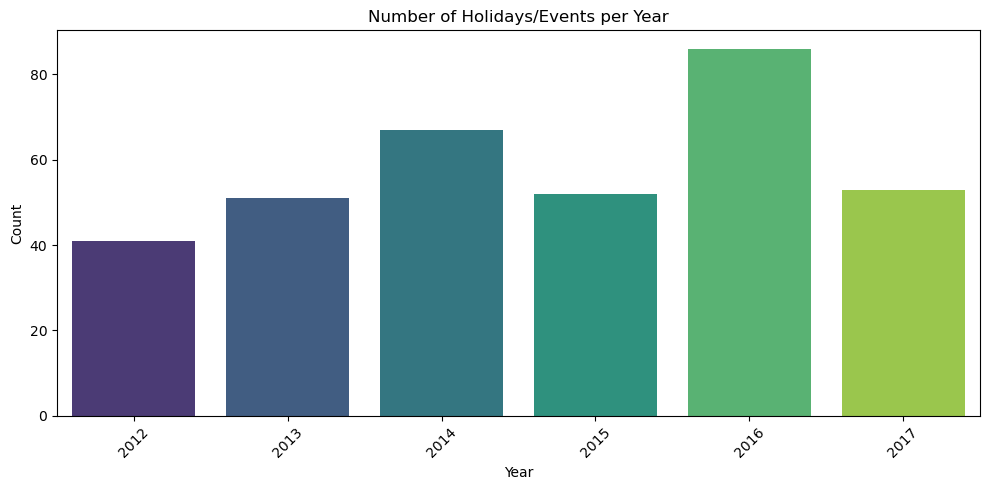

In [19]:
# Trend Analysis – Line Plot by Year

# Plot: Number of holidays/events per year
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='year', palette='viridis')
plt.title("Number of Holidays/Events per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

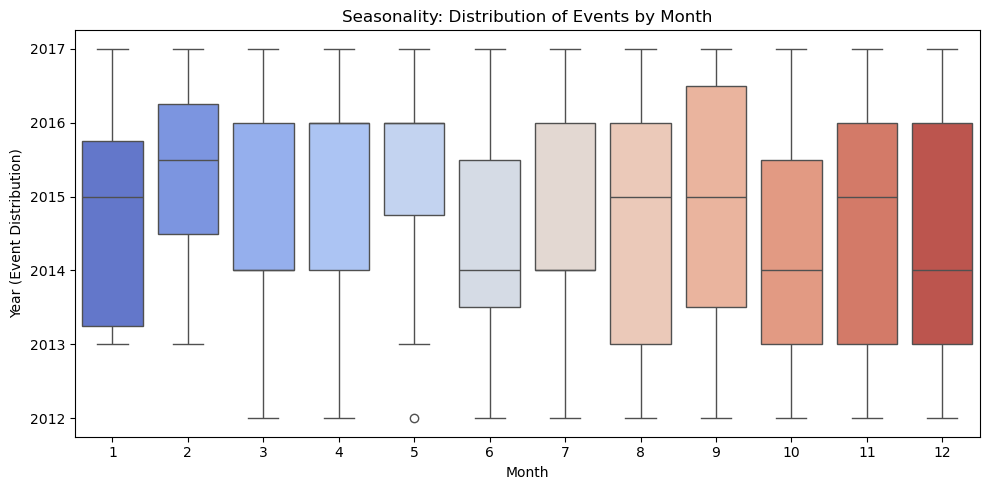

In [20]:
# Seasonality – Boxplot by Month

# Boxplot: Monthly distribution of events
plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='year', data=df, palette='coolwarm')
plt.title("Seasonality: Distribution of Events by Month")
plt.xlabel("Month")
plt.ylabel("Year (Event Distribution)")
plt.tight_layout()
plt.show()

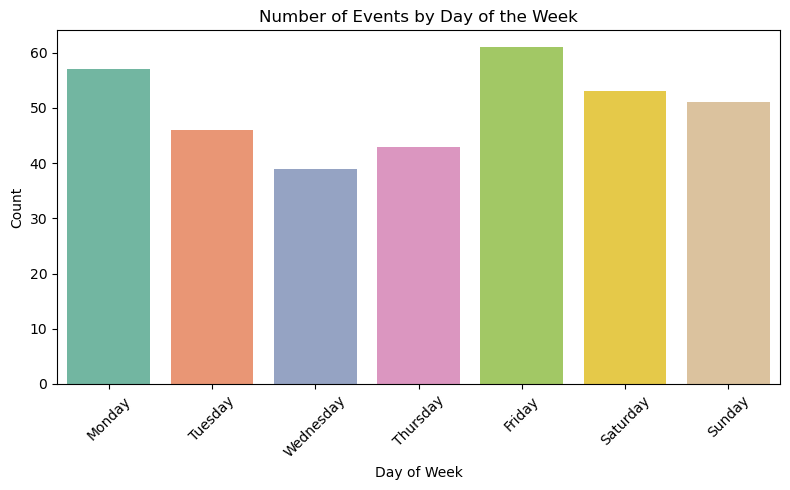

In [21]:
# Events by Day of the Week

# Count of events by day of the week
plt.figure(figsize=(8, 5))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='day_of_week', order=order, palette='Set2')
plt.title("Number of Events by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

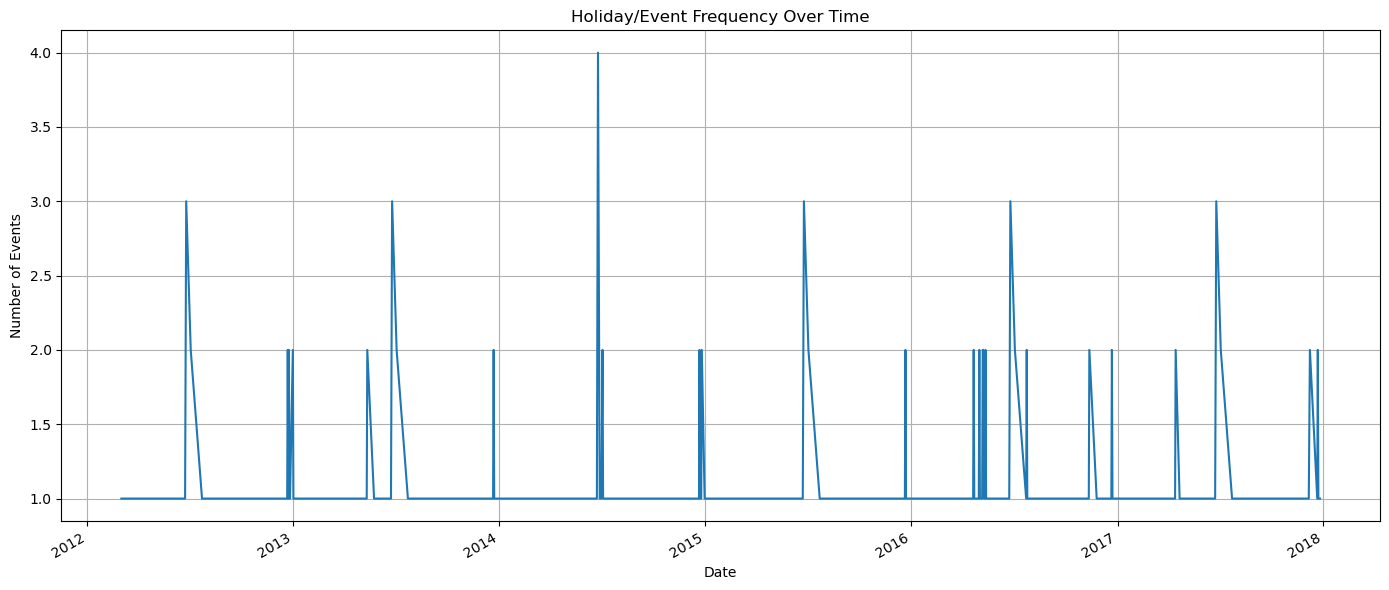

In [22]:
# Line Plot – Events Over Time

# Group by date for timeline plot
daily_counts = df.groupby('date').size()

plt.figure(figsize=(14, 6))
daily_counts.plot()
plt.title("Holiday/Event Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Below is the extended analysis that includes exploration based on type of event (e.g., Holiday, Event, Additional, etc.).

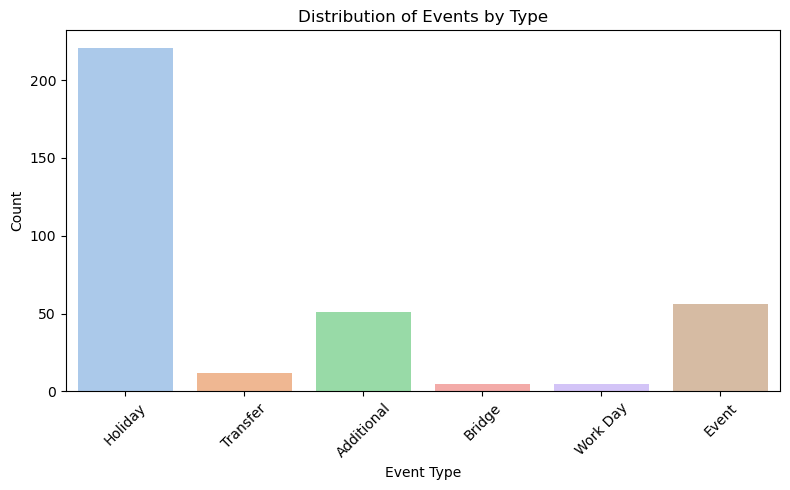

In [24]:
# Count of events by type

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='type', palette='pastel')
plt.title("Distribution of Events by Type")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

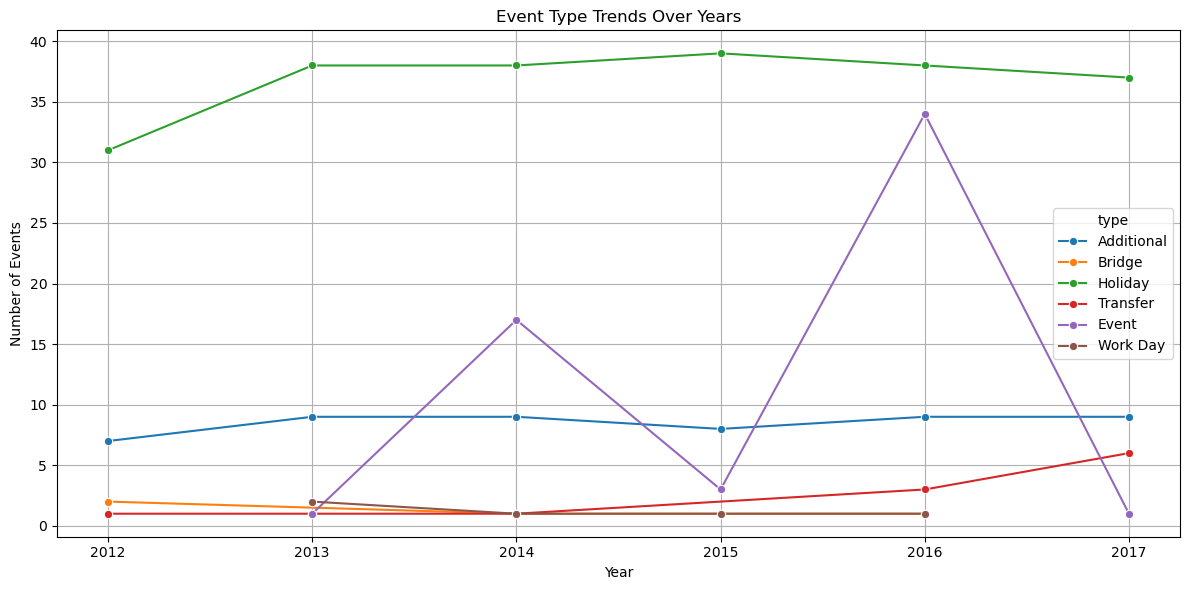

In [25]:
# Event Type Trends Over Time

# Group by year and type to show trends
type_trend = df.groupby(['year', 'type']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=type_trend, x='year', y='count', hue='type', marker='o')
plt.title("Event Type Trends Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.grid(True)
plt.tight_layout()
plt.show()

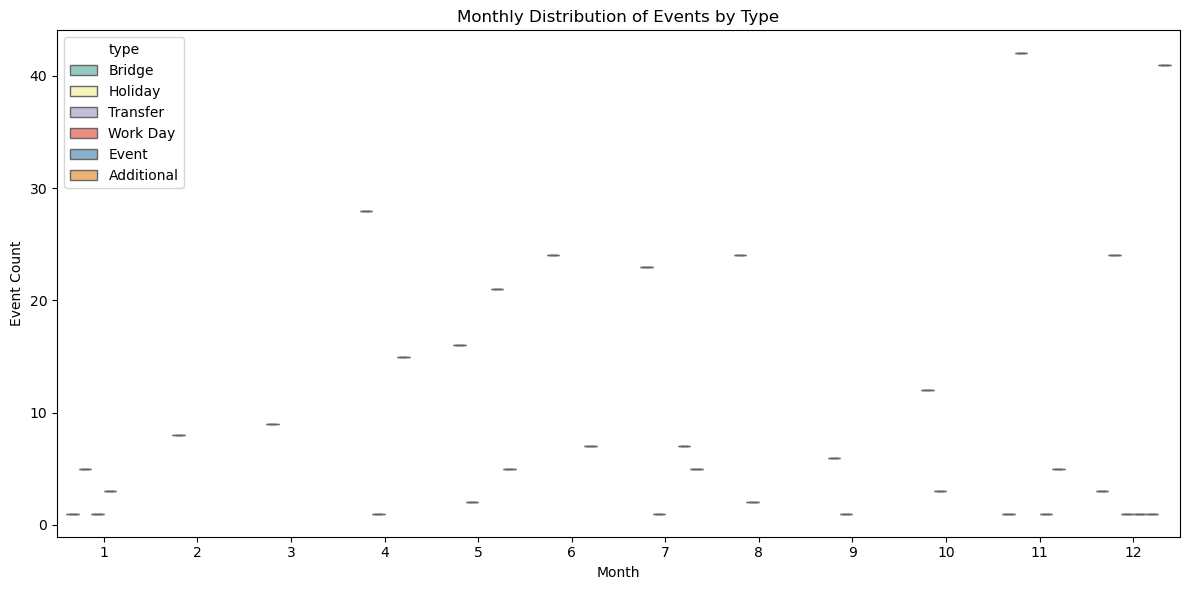

In [26]:
# Monthly Pattern by Event Type

# Group by month and type
monthly_type = df.groupby(['month', 'type']).size().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=monthly_type, x='month', y='count', hue='type', palette='Set3')
plt.title("Monthly Distribution of Events by Type")
plt.xlabel("Month")
plt.ylabel("Event Count")
plt.tight_layout()
plt.show()

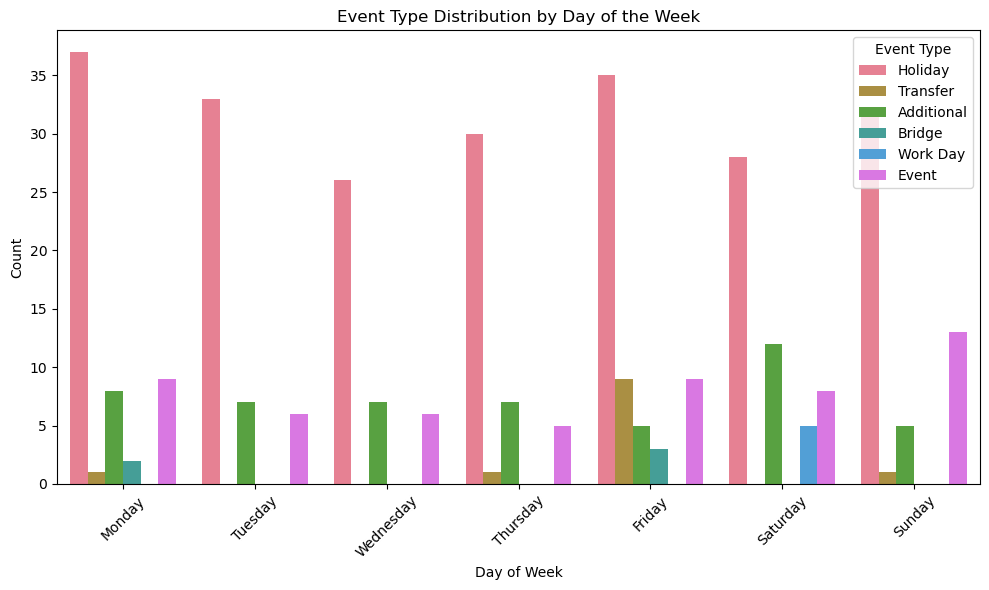

In [27]:
# Day of Week by Event Type

# Count of events by day and type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='day_of_week', hue='type', order=order, palette='husl')
plt.title("Event Type Distribution by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

# Feature Engineering 

In [29]:
# Create Base Time Series (Assumed Daily Sales)

# Generate a daily date range based on your data
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())

# Simulate a base DataFrame (replace with actual sales data if you have)
base_df = pd.DataFrame({'date': date_range})
base_df['sales'] = np.random.randint(100, 1000, size=len(base_df))  # Simulated sales

In [30]:
# xtract Date Features

# Convert date column
base_df['year'] = base_df['date'].dt.year
base_df['month'] = base_df['date'].dt.month
base_df['day_of_week'] = base_df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
base_df['is_weekend'] = base_df['day_of_week'] >= 5

In [31]:
 # Tried deriving more time-based features:

df['dayofweek'] = pd.to_datetime(df['date']).dt.dayofweek
df['month'] = pd.to_datetime(df['date']).dt.month
df['year'] = pd.to_datetime(df['date']).dt.year
df['is_weekend'] = df['dayofweek'].isin([5, 6])

In [32]:
# Add Lag Features

# Lag features (previous sales values)
base_df['lag_1'] = base_df['sales'].shift(1)
base_df['lag_7'] = base_df['sales'].shift(7)
base_df['lag_14'] = base_df['sales'].shift(14)

In [33]:
# Rolling Mean Features

# Rolling window average (smoothed past behavior)
base_df['rolling_mean_7'] = base_df['sales'].rolling(window=7).mean()
base_df['rolling_mean_14'] = base_df['sales'].rolling(window=14).mean()

In [34]:
# Merge Holiday Information

# Add a flag for whether a date is a holiday
holiday_dates = df[['date']].copy()
holiday_dates['is_holiday'] = 1

# Merge holiday flag
base_df = base_df.merge(holiday_dates, on='date', how='left')
base_df['is_holiday'] = base_df['is_holiday'].fillna(0)

In [35]:
# Final Preview of Engineered Features

# Preview the final dataset
base_df.head(15)

,date,sales,year,month,day_of_week,is_weekend,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14,is_holiday
0,2012-03-02,896,2012,3,4,False,NaN,NaN,NaN,NaN,NaN,1.0
1,2012-03-03,256,2012,3,5,True,896.0,NaN,NaN,NaN,NaN,0.0
2,2012-03-04,174,2012,3,6,True,256.0,NaN,NaN,NaN,NaN,0.0
3,2012-03-05,983,2012,3,0,False,174.0,NaN,NaN,NaN,NaN,0.0
4,2012-03-06,899,2012,3,1,False,983.0,NaN,NaN,NaN,NaN,0.0
5,2012-03-07,229,2012,3,2,False,899.0,NaN,NaN,NaN,NaN,0.0
6,2012-03-08,786,2012,3,3,False,229.0,NaN,NaN,603.285714,NaN,0.0
7,2012-03-09,183,2012,3,4,False,786.0,896.0,NaN,501.428571,NaN,0.0
8,2012-03-10,121,2012,3,5,True,183.0,256.0,NaN,482.142857,NaN,0.0
9,2012-03-11,558,2012,3,6,True,121.0,174.0,NaN,537.000000,NaN,0.0


In [36]:
# Summary of Engineered Features

# Feature	                           Description

# year, month	                       Extracted from date
# day_of_week	                       Integer from 0 (Mon) to 6 (Sun)
# is_weekend	                       Boolean flag for weekends
# lag_1, lag_7	                       Sales from previous 1, 7, 14 days
# rolling_mean_7	                   7-day rolling average of sales
# is_holiday	                       Flag from holiday/events data
# is_promo	                           Simulated promotion flag

# Model Building

In [38]:
# Create daily date range and simulate sales
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
daily_df = pd.DataFrame({'date': date_range})
np.random.seed(42)
daily_df['sales'] = np.random.randint(100, 1000, size=len(daily_df))

# Feature Engineering
daily_df['day_of_week'] = daily_df['date'].dt.dayofweek
daily_df['is_weekend'] = daily_df['day_of_week'] >= 5
holiday_dates = df[['date']].drop_duplicates()
holiday_dates['is_holiday'] = True
daily_df = pd.merge(daily_df, holiday_dates, on='date', how='left')
daily_df['is_holiday'] = daily_df['is_holiday'].fillna(False)

# Drop missing values if any (not needed here unless you add lags)
daily_df = daily_df.dropna()

In [39]:
# Convert boolean columns to integers
daily_df['is_holiday'] = daily_df['is_holiday'].astype(int)
daily_df['is_weekend'] = daily_df['is_weekend'].astype(int)

In [40]:
# SARIMAX Model

# Define exogenous features
exog_vars = ['is_holiday', 'is_weekend']
sarimax_model = SARIMAX(daily_df['sales'],
                        exog=daily_df[exog_vars],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 7))
sarimax_result = sarimax_model.fit()

# Forecast next 30 days
future_exog = daily_df[exog_vars].tail(30)
sarimax_forecast = sarimax_result.forecast(steps=30, exog=future_exog)

print("SARIMAX forecast:")
print(sarimax_forecast)

SARIMAX forecast:
2126    510.041033
2127    542.957548
2128    550.673956
2129    528.213512
2130    553.550898
2131    526.711633
2132    530.682480
2133    519.114037
2134    509.155290
2135    517.856980
2136    528.364906
2137    519.711830
2138    526.251445
2139    531.950831
2140    518.978707
2141    541.696878
2142    550.395786
2143    528.254774
2144    552.253523
2145    526.143040
2146    531.837544
2147    518.869384
2148    541.587474
2149    550.286390
2150    495.497346
2151    519.496084
2152    493.385608
2153    499.080126
2154    486.111955
2155    508.830044
Name: predicted_mean, dtype: float64


In [41]:
# Prophet Model

prophet_df = daily_df[['date', 'sales']].rename(columns={'date': 'ds', 'sales': 'y'})
holiday_df = df[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 1

# Instantiate and fit model
prophet = Prophet(holidays=holiday_df)
prophet.fit(prophet_df)

# Forecast next 30 days
future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

# Display forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:33:10 - cmdstanpy - INFO - Chain [1] start processing
11:33:11 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
2151,2018-01-21,575.164196,235.317982,920.372513
2152,2018-01-22,553.001701,239.761219,901.558670
2153,2018-01-23,562.267029,257.218154,883.798483
2154,2018-01-24,545.163643,220.910889,868.288581
2155,2018-01-25,567.334070,277.596879,892.850522


In [42]:
# Add necessary time-based features
daily_df['month'] = daily_df['date'].dt.month
daily_df['day_of_week'] = daily_df['date'].dt.dayofweek
daily_df['is_weekend'] = (daily_df['day_of_week'] >= 5).astype(int)
daily_df['is_holiday'] = daily_df['is_holiday'].astype(int)

# Lag features
daily_df['lag_1'] = daily_df['sales'].shift(1)
daily_df['lag_3'] = daily_df['sales'].shift(3)
daily_df['lag_7'] = daily_df['sales'].shift(7)

# Rolling averages
daily_df['rolling_mean_3'] = daily_df['sales'].rolling(window=3).mean()
daily_df['rolling_mean_7'] = daily_df['sales'].rolling(window=7).mean()

# Drop NA values caused by shifting/rolling
daily_df = daily_df.dropna()

In [43]:
# XGBoost Model

features = ['lag_1', 'lag_3', 'lag_7', 'rolling_mean_3', 'rolling_mean_7',
            'is_holiday', 'is_weekend', 'month', 'day_of_week']
X = daily_df[features]
y = daily_df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost MSE: {mse:.2f}")
print(f"XGBoost R² Score: {r2:.2f}")

XGBoost MSE: 44306.27
XGBoost R² Score: 0.33


 # Evaluate the Model

In [45]:
# Predictions already made: y_test (actual), y_pred (predicted)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 210.49
MAE: 168.86
MAPE: 46.36%


# Visualization & Reporting

In [47]:
# Redefine features list (make sure it's consistent)
features = ['lag_1', 'lag_3', 'lag_7', 'rolling_mean_3', 'rolling_mean_7',
            'is_holiday', 'is_weekend', 'month', 'day_of_week']

# Time-based split: 80% train, 20% test
split_index = int(len(daily_df) * 0.8)
train = daily_df.iloc[:split_index]
test = daily_df.iloc[split_index:]

X_train = train[features]
y_train = train['sales']
X_test = test[features]
y_test = test['sales']

# Re-train model if needed
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

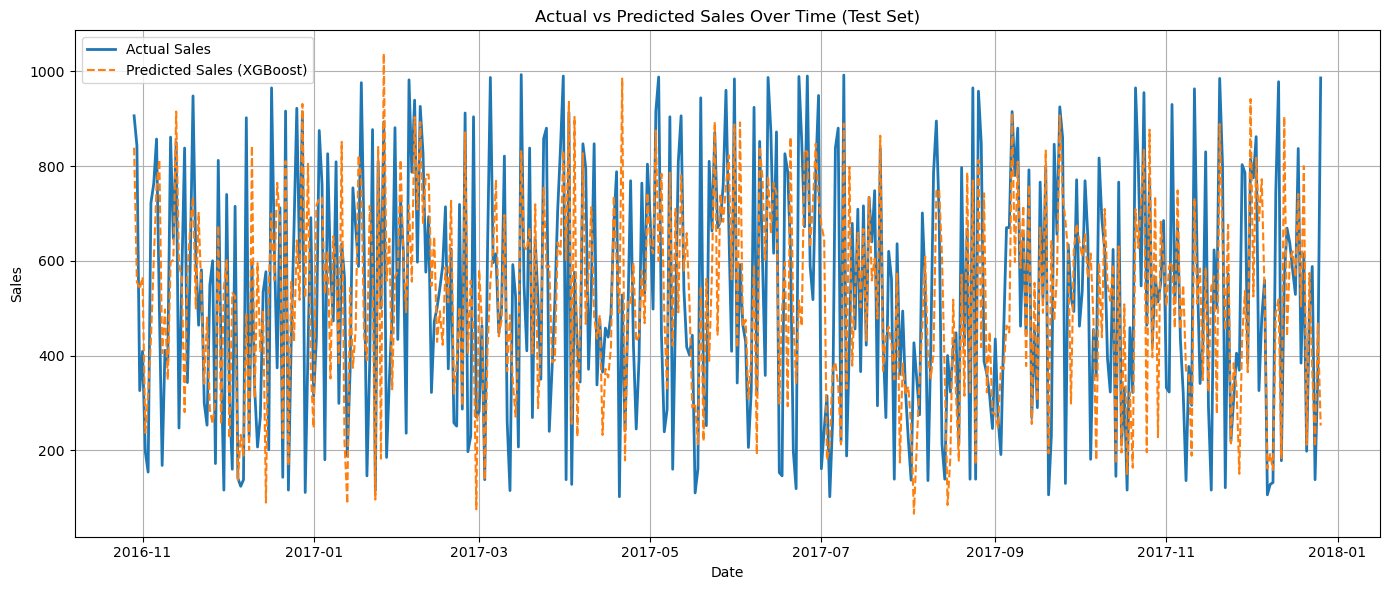

In [48]:
# Plot Actual vs Predicted Sales (Test Set)

plt.figure(figsize=(14, 6))
plt.plot(test['date'], y_test.values, label='Actual Sales', linewidth=2)
plt.plot(test['date'], y_pred, label='Predicted Sales (XGBoost)', linestyle='--')
plt.title('Actual vs Predicted Sales Over Time (Test Set)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
 # Visualize Error Across Dates

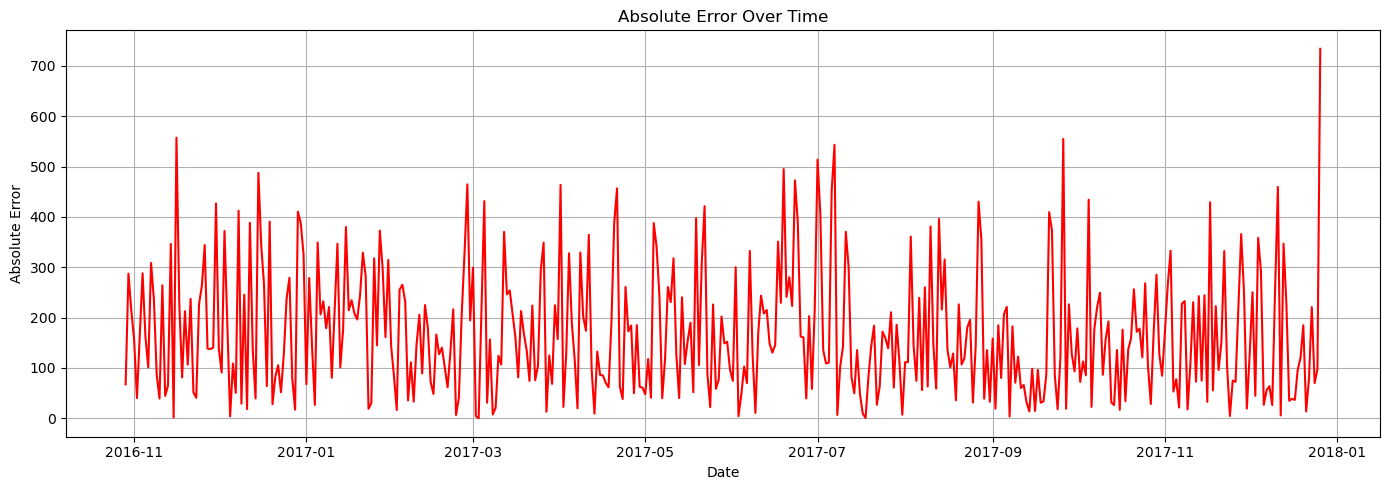

In [50]:
# Add error columns
test_result = test.copy()
test_result['predicted_sales'] = y_pred
test_result['error'] = test_result['sales'] - test_result['predicted_sales']
test_result['abs_error'] = test_result['error'].abs()

# Error Plot
plt.figure(figsize=(14, 5))
plt.plot(test_result['date'], test_result['abs_error'], color='red')
plt.title('Absolute Error Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Example: Assuming dataset is ready as X and y
# X = df.drop(columns=['sales'])
# y = df['sales']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<Figure size 1000x600 with 0 Axes>

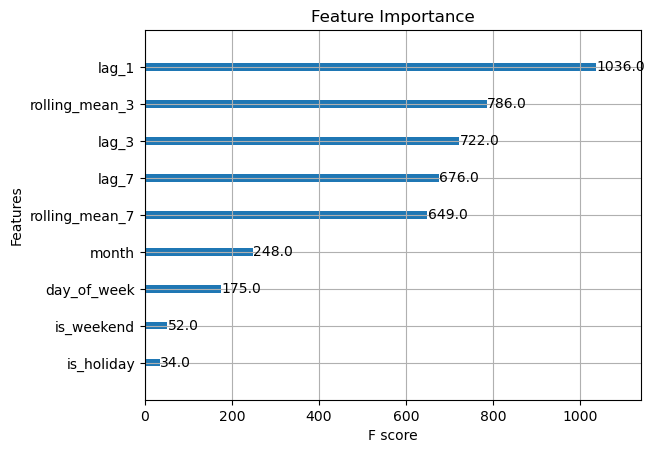

In [52]:
# Assuming xgb_model is our trained model

plt.figure(figsize=(10, 6))
plot_importance(xgb_model)
plt.title("Feature Importance")
plt.show()

In [53]:
# Cross-Validation Using TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"Fold RMSE: {rmse:.2f}")

Fold RMSE: 235.28
Fold RMSE: 229.19
Fold RMSE: 221.77
Fold RMSE: 225.94
Fold RMSE: 204.03


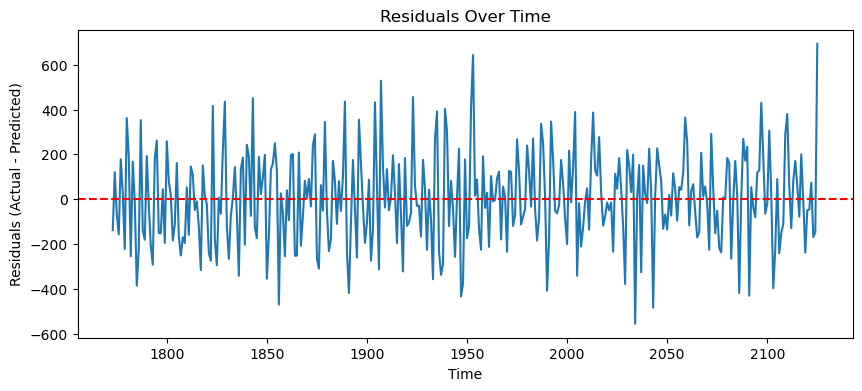

In [54]:
# Residual Plot (Error Analysis)

residuals = y_test - preds
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residuals (Actual - Predicted)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [55]:
# Model Persistence

# Save trained models for deployment
joblib.dump(xgb_model, "xgb_model.pkl")

['xgb_model.pkl']

In [56]:
# Optional: add a version or timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define filenames
xgb_filename = f"xgb_model_{timestamp}.pkl"
lr_filename = f"linear_model_{timestamp}.pkl"  # Example if you trained another model

# Save models
joblib.dump(xgb_model, xgb_filename)

# Optional: if you have other models
# joblib.dump(linear_model, lr_filename)

print(f"Models saved as: {xgb_filename}")

Models saved as: xgb_model_20250621_113318.pkl


In [57]:
# Evaluation Metrics Summary:

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Root Mean Squared Error (RMSE): 204.03
Mean Absolute Error (MAE): 162.57
R-squared (R²): 0.36


In [58]:
# Save metrics to a file
metrics = {
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2,
    "model_file": xgb_filename
}

import json
with open(f"metrics_{timestamp}.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Evaluation metrics saved.")

Evaluation metrics saved.
